In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Accident Risk Prediction with Custom Feature Importance & Error-Aware Stacking**

This project aims to predict accident risk using road, weather, and temporal features. Unlike typical approaches, it emphasizes:



*   Deep exploratory analysis
*   Feature-wise predictive power evaluation
*   A custom stacking model that learns from prediction errors





# 📊 Step 1: Initial Data Inspection

In [64]:
# Core libraries for numerical operations and data manipulation
import numpy as np
import pandas as pd

# Utility for splitting data into training and validation sets
from sklearn.model_selection import train_test_split

# Visualization libraries for exploratory data analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing tools for encoding and scaling features
from sklearn.preprocessing import OneHotEncoder, StandardScaler, _function_transformer, OrdinalEncoder, MinMaxScaler

# Pipeline and column-wise transformation utilities for clean preprocessing workflows
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Feature selection using sequential search (forward or backward)
from sklearn.feature_selection import SequentialFeatureSelector as sfs

# Gradient boosting model from XGBoost — powerful for tabular regression tasks
from xgboost import XGBRegressor

# Evaluation metric: Mean Absolute Error (MAE) for regression performance
from sklearn.metrics import mean_absolute_error , r2_score

# Ensemble model: Random Forest Regressor for baseline or comparison
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression

In [65]:
#train = pd.read_csv("../data/train.csv")
#predict = pd.read_csv("../data/test.csv")

In [66]:
# Load training data from CSV file
data = pd.read_csv("../data/train.csv")

# Drop the 'id' column as it's not informative for modeling
data = data.drop("id", axis=1)

# Display the dataset to verify successful loading and structure
data

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...
517749,highway,4,0.10,70,daylight,foggy,True,True,afternoon,False,False,2,0.32
517750,rural,4,0.47,35,daylight,rainy,True,True,morning,False,False,1,0.26
517751,urban,4,0.62,25,daylight,foggy,False,False,afternoon,False,True,0,0.19
517752,highway,3,0.63,25,night,clear,True,False,afternoon,True,True,3,0.51


In [67]:
# Display dataset structure, data types, and non-null counts
print("Data Info:\n")
print(data.info())

# Show the number of missing values per feature
print("\nMissing Values per Feature:\n")
print(data.isna().sum())

Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 37.5

# 🔍 Step 2: Exploratory Data Analysis (EDA)

<Axes: >

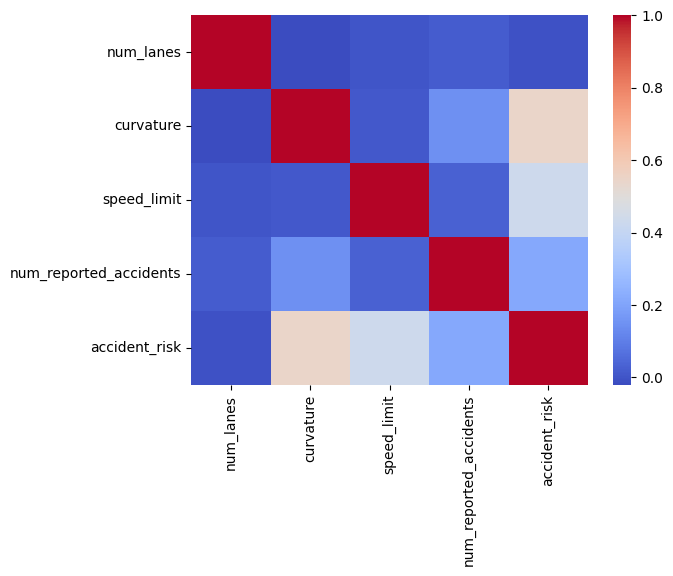

In [68]:
# Compute the correlation matrix for all numerical features
# Visualize feature relationships using a heatmap to identify potential multicollinearity or predictive patterns

corr = data.select_dtypes(["number"]).corr()
sns.heatmap(corr , cmap='coolwarm')

<Axes: xlabel='weather', ylabel='num_reported_accidents'>

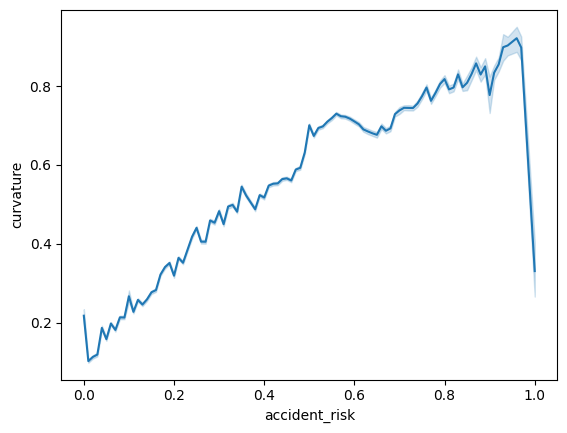

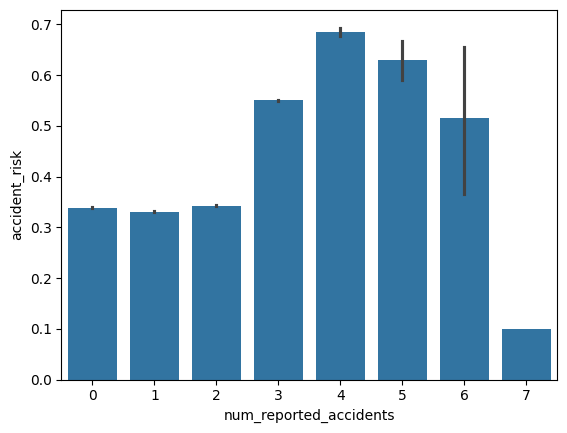

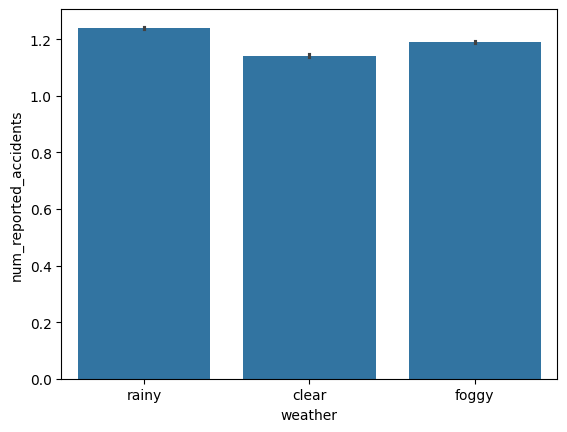

In [69]:
# 道路の曲率と事故リスクの関係を可視化する
plt.figure()
sns.lineplot(x='accident_risk', y='curvature', data=data)

# 報告された事故件数と事故リスクの相関を調べる
plt.figure()
sns.barplot(x='num_reported_accidents', y='accident_risk', data=data)

# 天候条件が報告された事故件数に与える影響を調べる
plt.figure()
sns.barplot(x='weather', y='num_reported_accidents', data=data)

<Axes: xlabel='lighting', ylabel='accident_risk'>

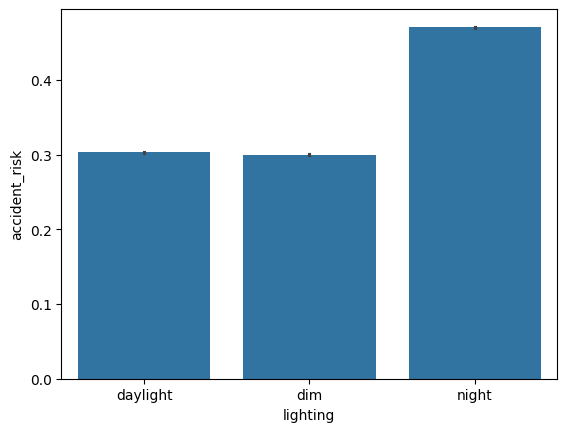

In [70]:
# Analyze how lighting conditions influence accident risk
sns.barplot(x='lighting', y='accident_risk', data=data)

<Axes: xlabel='lighting', ylabel='num_reported_accidents'>

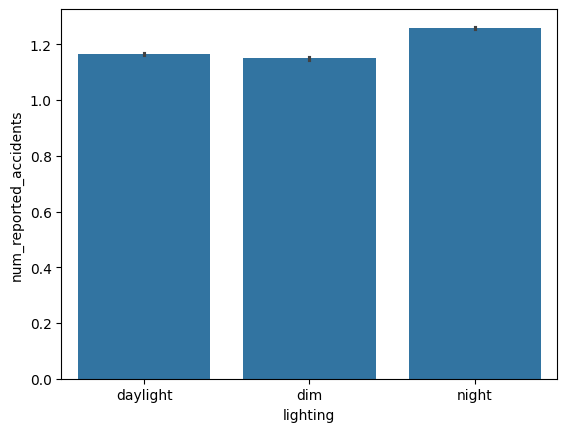

In [71]:
sns.barplot(x = 'lighting' , y='num_reported_accidents' , data = data)

🔍 **初期データの確認**  
- `train.csv` からデータセットを読み込みました。  
- 予測に役立たない `id` 列を削除しました。  
- データセットの構造を確認し、各特徴量に欠損値がないかをチェックしました。  

📈 **特徴量間の関係**  
- 折れ線グラフを用いて、`accident_risk`（事故リスク）と `curvature`（道路の曲率）の関係を可視化しました。  
- `num_reported_accidents`（報告された事故件数）が事故リスクとどのように相関しているかを分析しました。  
- `weather`（天候条件）が事故発生頻度に与える影響を調査しました。  
- 棒グラフを用いて、`lighting`（照明条件）が事故リスクに与える影響を評価しました。  

🧠 **主な考察**  
- `weather` や `lighting` のような特徴量は、強い予測的なシグナルを持っている可能性があります。  
- 一部の特徴量と目的変数の間には非線形な関係が見られます。  
- スケーリングやエンコーディングなど、さらなる前処理が必要です。


In [72]:
data_target = data['accident_risk']

# Split data into training and validation sets (80/20 split)
train_data, validate_data, y_train, y_validate = train_test_split(
    data.drop('accident_risk', axis=1),
    data_target,
    train_size=0.8,
    random_state=42,
    stratify=data_target
)


# 🧮 Step 3: Custom Feature Importance Function

### 🧠 特徴量重要度関数（Feature Importance Function）

このカスタム関数は、各特徴量の**予測力（predictive power）**を個別に評価します。  
主な処理内容は以下の通りです：

- データ型（カテゴリ型・ブール型・数値型）ごとに特徴量を選択  
- 適切な前処理を適用（例：OneHotEncoding、スケーリングなど）  
- 各特徴量単体でモデル（XGBoost または Random Forest）を学習  
- **平均絶対誤差（MAE）**を用いて性能を測定  

MAEが低いほど、その特徴量の予測価値が高いことを示します。

このアプローチにより、**目的変数に最も寄与する特徴量**を特定でき、  
後段のモデリングにおける特徴量選択の指針となります。


In [73]:
def feature_importance( X  , X_val , y  , y_val ,model = 'xgboost' ):
  # Identify unique data types in the dataset (e.g., object, bool, numeric)
  type_ = (X.dtypes).unique()
  feature_impact = []
  # Helper function to preprocess, train, and evaluate a single feature
  def train_valid(transformer ,train , valid_data , feature_ , type_data , y_val_):
    # Apply preprocessing pipeline to training and validation data
      train = transformer.fit_transform(train)
      valid = transformer.transform(valid_data)
      # Train XGBoost model on the transformed feature
      feature_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
      feature_model.fit(train , y)
      # Predict and evaluate using Mean Absolute Error
      predict = feature_model.predict(valid)
      mse = mean_absolute_error( predict, y_val_)
       # Store feature name and its corresponding MAE
      feature_impact.append((feature_ , mse , type_data))
      return feature_impact
  # Helper function to build preprocessing pipeline based on feature type
  def data_piplines(data_type_ = 'int64'):
    if data_type_ == 'O':
      # For categorical features: encode using Ordinal + OneHot
      pip = Pipeline([
          ("ordinal" , OrdinalEncoder()),
          ("ohe" , OneHotEncoder())
      ])

    elif data_type_ == 'bool' :
      pip = Pipeline([
          ("ordinal" , OrdinalEncoder())
      ])
    # For boolean features: encode using OrdinalEncoder
    elif data_type_ in ['int64' , 'float64'] :
      # For numeric features: scale using StandardScaler
      pip = Pipeline([
          ("scaler" , StandardScaler())
      ])
    return pip
  # Loop through each data type and evaluate feature importance
  for data_type in type_:
    # Select features of the current data type
    data_train = X.select_dtypes([data_type])
    data_validate = X_val.select_dtypes([data_type])
    data_col = (data_train.columns).tolist()

    if model == 'xgboost':
      for feature in data_col:
        # Build appropriate pipeline and transformer for the feature
        if data_type == 'O':
          pip = data_piplines(data_type)
          # Train and evaluate the feature
          transformer = ColumnTransformer([('onehot', pip, [feature])], remainder='drop')
          train_valid(transformer , train = data_train ,valid_data= data_validate , feature_=feature , type_data=data_type , y_val_=y_val)

        elif data_type == 'bool' :
          pip = data_piplines(data_type)
          transformer = ColumnTransformer([
              ('onehot', pip, [feature])
              ], remainder='drop')

          train_valid(transformer , train = data_train ,valid_data= data_validate , feature_=feature , type_data=data_type , y_val_=y_val)

        elif data_type == 'int64' or data_type == 'float64' :
          pip = data_piplines(data_type)
          transformer = ColumnTransformer([
              ('onehot', pip, [feature])
              ], remainder='drop')
          train_valid(transformer , train = data_train ,valid_data= data_validate , feature_=feature , type_data=data_type , y_val_=y_val)


    elif model == 'random_forest':
      for feature in data_col:
        feature_model = RandomForestRegressor(n_estimators=1000, random_state=42)
        feature_model.fit(data_train[feature] , y)
        feature_impact.append((feature , mean_absolute_error(feature_model.predict(valid) , y_val)))
  feature_importance = pd.DataFrame(feature_impact , columns=['col' , 'mse' , 'type'])
  return feature_importance.sort_values(by='mse')




In [74]:
# Evaluate feature importance using custom function
# This function trains a model on each feature individually and computes its MAE on validation data
# Lower MAE indicates higher predictive value for the target variable (accident_risk)
f_impact = feature_importance(X = train_data, X_val = validate_data, y_val = y_validate, y = y_train)

# Display the resulting DataFrame showing each feature's name, MAE score, and data type
f_impact


,col,mse,type
7,curvature,0.112299,float64
5,speed_limit,0.117219,int64
1,lighting,0.119422,object
6,num_reported_accidents,0.124281,int64
2,weather,0.130981,object
10,holiday,0.132632,bool
9,public_road,0.132793,bool
0,road_type,0.132839,object
4,num_lanes,0.132868,int64
11,school_season,0.132894,bool


<Axes: xlabel='col', ylabel='mse'>

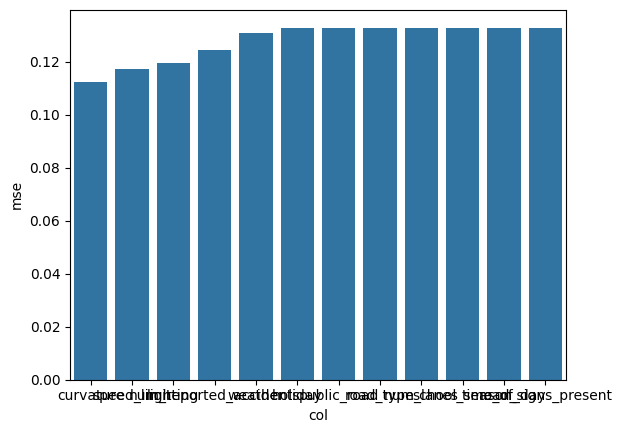

In [75]:
# Visualize feature importance scores using a bar plot
# Each bar represents a feature, and its height corresponds to the MAE (lower is better)
sns.barplot(x = f_impact['col'], y = f_impact['mse'])


In [76]:
# 学習データセットから特定の特徴量を削除する
# これらの特徴量は、冗長・影響が小さい、または事前の分析結果に基づいて削除される可能性がある
train_data = train_data.drop(['road_signs_present', 'time_of_day', 'num_lanes'], axis=1)


In [77]:
f_impact = feature_importance(X = train_data, X_val = validate_data, y_val = y_validate, y = y_train)
f_impact

KeyboardInterrupt: 

# 🧼 Step 4: Feature Preprocessing Pipeline

In [ ]:
# 各特徴量の型に応じて適切な前処理を適用するための ColumnTransformer を構築
transformer = ColumnTransformer([
    # カテゴリ型（object型）の特徴量には OneHotEncoder を適用
    ("ohe", OneHotEncoder(), f_impact[f_impact['type'] == 'object']['col'].tolist()),

    # 数値型（int64 または float64）の特徴量には MinMaxScaler を適用
    ("scaler", MinMaxScaler(), f_impact[(f_impact['type'] == 'int64') | (f_impact['type'] == 'float64')]['col'].tolist()),

    # ブール型（bool型）の特徴量には OrdinalEncoder を適用
    ("ordinal", OrdinalEncoder(), f_impact[f_impact['type'] == 'bool']['col'].tolist())
], remainder="passthrough")  # それ以外の列は変更せずにそのまま残す


In [ ]:
# トレーニングデータに対して前処理器（transformer）を適用し、変換を実行
train = transformer.fit_transform(train_data)

# 変換後のトレーニングデータを DataFrame に変換し、列名を適切に設定
train = pd.DataFrame(train, columns=transformer.get_feature_names_out())

# 同じ前処理を検証データ（validation data）にも適用
validate = transformer.transform(validate_data)

# 変換後の検証データも DataFrame に変換し、列名を統一
validate = pd.DataFrame(validate, columns=transformer.get_feature_names_out())

# **Modeling**

# 🧠 Step 5: Error-Aware Stacking Model

### 🔁 カスタムスタッキングモデル：`StackErorModel`

このクラスは、回帰タスク向けに設計された**カスタムスタッキング手法**を実装しています。  
従来のスタッキングが「各モデルの予測値」を組み合わせるのに対し、  
この手法では**クロスバリデーションごとの誤差情報（予測誤差）**を学習に活用します。  

つまり、「どの部分でモデルが間違えやすいか（残差パターン）」を捉えることで、  
より汎化性能の高い最終モデルを構築します。

---

#### 📦 **主な特徴**

- **CatBoost**, **XGBoost**, **Linear Regression** をベースモデルとして利用可能  
- **クロスバリデーション（CV）** を用いて、誤差ベースの特徴量を生成  
- 誤差特徴量を使って **CatBoost のメタモデル**（最終モデル）を学習  
- 各分割ごとの学習済みモデル（`model0.cbm`, `model1.cbm`, …）を自動保存し、再現性を確保  

---

#### 🧠 **この手法が効果的な理由**

従来のスタッキングでは、単に複数モデルの**予測値を平均または結合**します。  
しかしこのモデルは一歩進んで：

- 各分割（fold）でのモデルが「見たことのないデータ」に対してどのように誤るかを分析  
- **絶対誤差（|y - ŷ|）** を特徴量として扱い、「どの条件で誤差が大きくなるか」を学習  
- その誤差パターンをもとに、**誤りを補正するメタモデル**を構築  

これにより、**単純な予測の平均よりも高精度で安定した最終予測**が可能になります。

---

#### 🛠️ **使用例**
```python
stack_model = StackErorModel(
    data=X_train,          # 学習データ
    target=y_train,        # 学習ラベル
    test=X_test,           # テストデータ
    test_target=y_test,    # テストラベル
    model='catboost',      # ベースモデルの種類
    cv=3                   # クロスバリデーション分割数
)

# モデルの学習
stack_model.fit(None)

# 変換後の特徴量と最終モデルを取得
final_model, test_features, test_targets = stack_model.transform(None)


In [ ]:
#"""
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np

# StackErrorModel: クロスバリデーションの各分割で予測誤差を学習するスタッキングモデル
# 主に回帰タスク（数値予測）を対象とし，CatBoost，XGBoost，線形回帰に対応
class StackErorModel(BaseEstimator, TransformerMixin):

    def __init__(self, data, target, test, test_target, model='catboost', cv=3) -> None:
        # トレーニングデータとテストデータを保持
        self.data = data
        self.target = target
        self.test = test
        self.test_target = test_target
        self.cv = cv  # クロスバリデーションの分割数（fold数）

        # クロスバリデーションの分割データや最終学習用データを格納するコンテナを初期化
        self.cv_data = []
        self.fainal_data = pd.DataFrame()
        self.fainal_target = pd.DataFrame()
        self.fainal_test_data = pd.DataFrame()
        self.fainal_test_target = pd.DataFrame()

        # 使用するベースモデルを選択（引数modelで指定）
        if model == 'LinearRegression':
            self.model = LinearRegression()
        elif model == 'XGBoost':
            self.model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
        elif model == 'catboost':
            # 各foldでの学習に使用するCatBoostモデル
            self.model = CatBoostRegressor(
                iterations=1500,
                learning_rate=0.07,
                depth=10,
                verbose=100,
                loss_function='RMSE',
                random_strength=5,
                l2_leaf_reg=10
            )
            # foldごとの誤差情報を使って学習する最終モデル
            self.fainal_model = CatBoostRegressor(
                iterations=1500,
                learning_rate=0.8,
                depth=9,
                verbose=100,
                loss_function='RMSE',
                random_strength=5,
                l2_leaf_reg=10
            )

    def fit(self, x, y=None):
        # クロスバリデーションを実施し，各foldの予測誤差を収集
        for i in range(self.cv):
            # データを学習用と検証用に分割
            train, valid, y_train, y_valid = train_test_split(
                self.data, self.target, test_size=0.2, random_state=i
            )
            valid = valid.reset_index(drop=True)
            y_valid = y_valid.reset_index(drop=True)
            # 各foldのデータを保存
            self.cv_data.append((train, valid, y_train, y_valid))

        count = 0
        for train, valid, y_train, y_valid in self.cv_data:
            # ベースモデルを学習
            self.model.fit(train, y_train)
            # 検証データで予測
            prediction = self.model.predict(valid)

            # 絶対誤差を計算し，その情報を次の学習用データに保存
            absolute_error = np.abs(np.array(prediction) - np.array(y_valid))
            self.fainal_data["absolute_error"] = absolute_error
            self.fainal_data["prediction"] = prediction
            self.fainal_target["target"] = y_valid

            # 最初のfoldのときはテストデータでも同様に誤差を算出
            if count == 0:
                self.test = self.test.reset_index(drop=True)
                self.target = self.target.reset_index(drop=True)
                test_pred = self.model.predict(self.test)
                test_absolute_error = np.abs(np.array(test_pred) - np.array(self.test_target))
                self.fainal_test_data["absolute_error"] = test_absolute_error
                self.fainal_test_data["prediction"] = test_pred
                self.fainal_test_target["target"] = self.test_target

                # 誤差を特徴量として最終モデルを学習
                self.fainal_model.fit(self.fainal_data, self.fainal_target)
                # 学習済みモデルを保存
                self.fainal_model.save_model(f'model{count}.cbm')
            else:
                # 2回目以降は前回のモデルを初期値として継続学習
                self.fainal_model.fit(
                    self.fainal_data, self.fainal_target, init_model=f'model{count-1}.cbm'
                )
                self.fainal_model.save_model(f'model{count}.cbm')

            count += 1

        return self

    def transform(self, x, y=None):
        # 学習済みの最終モデルと，誤差特徴を含むテストデータを返す
        return self.fainal_model, self.fainal_test_data, self.fainal_test_target
#"""

'\nfrom sklearn.base import BaseEstimator, TransformerMixin\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.model_selection import train_test_split\nfrom xgboost import XGBRegressor\nfrom catboost import CatBoostRegressor\nimport pandas as pd\nimport numpy as np\n\n# StackErrorModel: クロスバリデーションの各分割で予測誤差を学習するスタッキングモデル\n# 主に回帰タスク（数値予測）を対象とし，CatBoost，XGBoost，線形回帰に対応\nclass StackErorModel(BaseEstimator, TransformerMixin):\n\n    def __init__(self, data, target, test, test_target, model=\'catboost\', cv=3) -> None:\n        # トレーニングデータとテストデータを保持\n        self.data = data\n        self.target = target\n        self.test = test\n        self.test_target = test_target\n        self.cv = cv  # クロスバリデーションの分割数（fold数）\n\n        # クロスバリデーションの分割データや最終学習用データを格納するコンテナを初期化\n        self.cv_data = []\n        self.fainal_data = pd.DataFrame()\n        self.fainal_target = pd.DataFrame()\n        self.fainal_test_data = pd.DataFrame()\n        self.fainal_test_target = pd.DataFrame()\n\

In [ ]:
stack_model = staticmethod(data=train , target=y_train , test = validate , test_target=y_validate , model='catboost' , cv=3)
model , test , target= stack_model.fit_transform(train)

[I 2025-10-21 09:56:46,674] A new study created in memory with name: no-name-42d4c364-abd4-43af-8846-d5afcd3e1250
[I 2025-10-21 09:56:46,852] Trial 0 finished with value: 0.07883897039456778 and parameters: {'learning_rate': 0.11425067823187823, 'depth': 5, 'l2_leaf_reg': 7.148348759442607, 'random_strength': 9.957087111159405}. Best is trial 0 with value: 0.07883897039456778.
[I 2025-10-21 09:56:47,068] Trial 1 finished with value: 0.09699821143825137 and parameters: {'learning_rate': 0.06821289599442201, 'depth': 8, 'l2_leaf_reg': 1.4726972549064012, 'random_strength': 1.4349951066607762}. Best is trial 0 with value: 0.07883897039456778.
[I 2025-10-21 09:56:47,408] Trial 2 finished with value: 0.06377767212082766 and parameters: {'learning_rate': 0.16958160735901426, 'depth': 11, 'l2_leaf_reg': 12.371627412047422, 'random_strength': 8.125510982142018}. Best is trial 2 with value: 0.06377767212082766.
[I 2025-10-21 09:56:47,639] Trial 3 finished with value: 0.07368203964290305 and par

Best CatBoost Params: {'learning_rate': 0.2792297379055119, 'depth': 10, 'l2_leaf_reg': 13.59930323470633, 'random_strength': 2.3489572981114364}
0:	learn: 0.1270924	total: 24.2ms	remaining: 24.2s
1:	learn: 0.1005525	total: 45.6ms	remaining: 22.8s
2:	learn: 0.0829253	total: 68.6ms	remaining: 22.8s
3:	learn: 0.0718296	total: 93.1ms	remaining: 23.2s
4:	learn: 0.0655428	total: 106ms	remaining: 21.1s
5:	learn: 0.0616931	total: 129ms	remaining: 21.4s
6:	learn: 0.0594809	total: 152ms	remaining: 21.6s
7:	learn: 0.0582698	total: 177ms	remaining: 22s
8:	learn: 0.0575617	total: 199ms	remaining: 22s
9:	learn: 0.0571552	total: 223ms	remaining: 22s
10:	learn: 0.0569313	total: 245ms	remaining: 22.1s
11:	learn: 0.0567823	total: 268ms	remaining: 22s
12:	learn: 0.0566827	total: 294ms	remaining: 22.3s
13:	learn: 0.0566347	total: 321ms	remaining: 22.6s
14:	learn: 0.0565879	total: 345ms	remaining: 22.6s
15:	learn: 0.0565471	total: 374ms	remaining: 23s
16:	learn: 0.0565001	total: 410ms	remaining: 23.7s
17:

# 📈 Step 6: Final Evaluation

In [ ]:
# Generate predictions on the test set using the final model
pered = model.predict(test)

# Evaluate model performance using Mean Absolute Error (MAE)
print(mean_absolute_error(target, pered))  # Lower MAE indicates better accuracy

# Compute R² score to assess goodness of fit
print(r2_score(target, pered))  # Closer to 1 means better explanatory power


0.03583666982751235
0.9081553694093253


🎯 Extremely low MAE and high R² indicate strong predictive performance and reliability.